In [1]:

import os
import json
import pandas as pd
from tqdm import tqdm
import polars as pl
from pathlib import Path
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from pathlib import Path
import numpy as np
t=25
fx=12
fy=10


In [2]:
# Funzione aggiornata
def compute_vci_and_Judgement(row):
    votes_def = row['votes_defending']
    votes_against = row['votes_against']
    
    # --- VCI come nel tuo esempio ---
    min_votes = min(votes_against, votes_def)
    max_votes = max(votes_against, votes_def)
    if max_votes == 0:
        vci = 0
    else:
        balance = min_votes / max_votes
        discussion_score = votes_against + votes_def  # somma dei voti
        discussion_term = np.log1p(discussion_score)
        vci = balance * 1  # qui puoi reinserire discussion_term se lo volevi
    
    # --- Leaning ---
    total = votes_against + votes_def
    if total == 0:
        leaning = 0
    else:
        leaning = (votes_def - votes_against) / total
    
    return pd.Series({"VCI": vci, "Judgement": leaning})

## Simulation

In [45]:
import pandas as pd 


columns = [
    "note_id",
    "step",
    "agent_id",
    "tweet_id",
    "note",
    "classification",
    "urls",
    "misleading_other",
    "misleading_factual_error",
    "misleading_manipulated_media",
    "misleading_outdated_information",
    "misleading_missing_important_context",
    "misleading_unverified_claim_as_fact",
    "misleading_satire",
    "not_misleading_other",
    "not_misleading_factually_correct",
    "not_misleading_outdated",
    "not_misleading_clearly_satire",
    "not_misleading_personal_opinion",
    "cites_trustworthy_sources",
    "opened_link",
    "internet_search"
]

notes_simulated = pd.read_csv(
    "/home/jacoponudo/Documents/LLM-CommunityNotes/data/simulations/simulation0/notes_simulation.csv",
    sep=",",
    header=None,
    on_bad_lines="skip",
    names=columns
)

notes_simulated = notes_simulated[notes_simulated["classification"].isin(["misleading", "not_misleading"])]
notes_simulated['classification'].value_counts()
notes_simulated['note_id'].nunique()

793

In [46]:
columns = [
    "id",
    "step",
    "agent_id",
    "tweet_id",
    "opened_link",
    "internet_search"
]
observations_simulated = pd.read_csv(
    '/home/jacoponudo/Documents/LLM-CommunityNotes/data/simulations/simulation0/observations_simulation.csv',
    sep=',',
    header=None,
    on_bad_lines='skip',
    names=columns
)


In [47]:
columns = [
    "id",
    "step",
    "agent_id",
    "tweet_id",
    "note_id",
    "agree",
    "helpfulness",
    "helpful_other",
    "helpful_clear",
    "helpful_good_sources",
    "helpful_addresses_claim",
    "helpful_important_context",
    "helpful_unbiased_language",
    "not_helpful_other",
    "not_helpful_incorrect",
    "not_helpful_sources_missing_or_unreliable",
    "not_helpful_missing_keypoints",
    "not_helpful_hard_to_understand",
    "not_helpful_argumentative_or_biased",
    "not_helpful_spam_or_abuse",
    "not_helpful_irrelevant_sources",
    "not_helpful_opinion_speculation",
    "not_helpful_note_not_needed",
    "opened_link",
    "internet_search"
]

ratings_simulated = pd.read_csv(
    '/home/jacoponudo/Documents/LLM-CommunityNotes/data/simulations/simulation0/ratings_simulation.csv',
    sep=',',
    header=None,
    on_bad_lines='skip',
    names=columns
)


tweeets to consider 

In [48]:
unique_tweet_ids = pd.concat([
    ratings_simulated['tweet_id'],
    notes_simulated['tweet_id'],
    observations_simulated['tweet_id']
]).unique()

In [49]:
unique_tweet_ids
notes_simulated['tweet_id'] = notes_simulated['tweet_id'].astype(str)

ratings_simulated = ratings_simulated[['note_id', 'helpfulness']].merge(
    notes_simulated[['note_id', 'tweet_id','classification']], 
    on='note_id', 
    how='left'
)
# Calcolare votes_against: helpful & misleading + not helpful & not misleading
ratings_simulated['votes_against'] = ((ratings_simulated['helpfulness'] == 'helpful') & (ratings_simulated['classification'] == 'misleading')).astype(int) + \
                      ((ratings_simulated['helpfulness'] == 'not_helpful') & (ratings_simulated['classification'] == 'not_misleading')).astype(int)

# Calcolare votes_defending: not helpful & misleading + helpful & not misleading
ratings_simulated['votes_defending'] = ((ratings_simulated['helpfulness'] == 'not_helpful') & (ratings_simulated['classification'] == 'misleading')).astype(int) + \
                        ((ratings_simulated['helpfulness'] == 'helpful') & (ratings_simulated['classification'] == 'not_misleading')).astype(int)

# Assicurati che entrambi siano stringhe
unique_tweet_ids_df = pd.DataFrame(unique_tweet_ids.astype(str), columns=['tweet_id'])
ratings_simulated['tweet_id'] = ratings_simulated['tweet_id'].astype(str)

tweet_ratings_simulated = ratings_simulated.groupby('tweet_id').agg({
    'votes_against': 'sum',
    'votes_defending': 'sum'
}).reset_index()

tweet_ratings_simulated = (
    unique_tweet_ids_df
    .merge(tweet_ratings_simulated, on='tweet_id', how='left')
    .fillna({'votes_against': 0, 'votes_defending': 0})
)
tweet_ratings_simulated['votes_against'] = tweet_ratings_simulated['votes_against'].astype(int)
tweet_ratings_simulated['votes_defending'] = tweet_ratings_simulated['votes_defending'].astype(int)
tweet_ratings_simulated[['VCI', 'Judgement']] = tweet_ratings_simulated.apply(compute_vci_and_Judgement, axis=1).fillna(0)

## Observed

In [50]:
import pandas as pd

# Load notes
notes = pd.read_csv(
    "/home/jacoponudo/Documents/LLM-CommunityNotes/data/notes/notes-00000.tsv",
    sep="\t"
)

# Ensure both columns are strings
notes['tweetId'] = notes['tweetId'].astype(str)
unique_tweet_ids=unique_tweet_ids.astype(str)
notes_observed = notes[notes['tweetId'].isin((unique_tweet_ids))]


/tmp/ipykernel_16098/4027387225.py:4: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv(


In [51]:

# Cartella contenente i file JSON/TSV
folder_path = "/home/jacoponudo/Documents/community_notes/data"
folder = Path(folder_path+"/ratings")
tsv_files = list(folder.glob("ratings-*.tsv"))

# Assumiamo notes come DataFrame Polars
# notes = pl.read_json("path/to/notes.json")
note_ids = notes_observed['noteId'].to_list()

# Lazy read + filtro
lazy_frames = [
    pl.scan_csv(f, separator="\t", has_header=True)
    for f in tsv_files
]

ratings = pl.concat(lazy_frames)
ratings_observed=ratings.filter(pl.col('noteId').is_in(note_ids)).select(['noteId','raterParticipantId','helpfulnessLevel','ratedOnTweetId']).collect().to_pandas()
ratings_observed=ratings_observed.merge(notes_observed[['noteId','classification']], on='noteId', how='left')

Here we calculate for each tweet how many users or agent voted against or in defence.

In [52]:


# Rinominare e standardizzare i valori
ratings_observed_standardized = ratings_observed.rename(columns={
    'noteId': 'note_id',
    'helpfulnessLevel': 'rating',
    'classification': 'type',
    'ratedOnTweetId': 'tweet_id'
})

# Convertire valori in minuscolo per uniformità
ratings_observed_standardized['rating'] = ratings_observed_standardized['rating'].str.lower()
ratings_observed_standardized['rating'] = ratings_observed_standardized['rating'].replace({
    'helpful': 'helpful',
    'not_helpful': 'not_helpful'
})

ratings_observed_standardized['type'] = ratings_observed_standardized['type'].replace({
    'MISINFORMED_OR_POTENTIALLY_MISLEADING': 'misleading',
    'NOT_MISLEADING': 'not_misleading'
})

# Assicurarsi che tweet_id sia stringa
ratings_observed_standardized['tweet_id'] = ratings_observed_standardized['tweet_id'].astype(str)

# Calcolo votes_against
ratings_observed_standardized['votes_against'] = (
    ((ratings_observed_standardized['rating'] == 'helpful') & (ratings_observed_standardized['type'] == 'misleading')).astype(int) +
    ((ratings_observed_standardized['rating'] == 'not_helpful') & (ratings_observed_standardized['type'] == 'not_misleading')).astype(int)
)

# Calcolo votes_defending
ratings_observed_standardized['votes_defending'] = (
    ((ratings_observed_standardized['rating'] == 'not_helpful') & (ratings_observed_standardized['type'] == 'misleading')).astype(int) +
    ((ratings_observed_standardized['rating'] == 'helpful') & (ratings_observed_standardized['type'] == 'not_misleading')).astype(int)
)

# Aggregazione per tweet
tweet_ratings_observed = ratings_observed_standardized.groupby('tweet_id').agg({
    'votes_against': 'sum',
    'votes_defending': 'sum'
}).reset_index()




# Applicazione al DataFrame
tweet_ratings_observed[['VCI', 'Judgement']] = tweet_ratings_observed.apply(compute_vci_and_Judgement, axis=1)
tweet_ratings_observed = (
    unique_tweet_ids_df
    .merge(tweet_ratings_observed, on='tweet_id', how='left')
    .fillna({'votes_against': 0, 'votes_defending': 0})
)
tweet_ratings_observed['votes_against'] = tweet_ratings_observed['votes_against'].astype(int)
tweet_ratings_observed['votes_defending'] = tweet_ratings_observed['votes_defending'].astype(int)
tweet_ratings_observed=tweet_ratings_observed.fillna(0)

## Comparison

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unire i DataFrame
merged = tweet_ratings_observed.merge(
    tweet_ratings_simulated, 
    on='tweet_id', 
    suffixes=('_observed', '_simulated')
)
merged

,tweet_id,votes_against_observed,votes_defending_observed,VCI_observed,Judgement_observed,votes_against_simulated,votes_defending_simulated,VCI_simulated,Judgement_simulated
0,1384273265829416960,0,0,0.000000,0.000000,318,12,0.037736,-0.927273
1,1547586884376834049,0,0,0.000000,0.000000,282,57,0.202128,-0.663717
2,1586499372648484864,0,0,0.000000,0.000000,452,0,0.000000,-1.000000
3,1587932950712225794,0,0,0.000000,0.000000,387,0,0.000000,-1.000000
4,1600977526909706240,0,0,0.000000,0.000000,350,3,0.008571,-0.983003
...,...,...,...,...,...,...,...,...,...
653,1722687813148356983,257,299,0.859532,0.075540,0,0,0.000000,0.000000
654,1652147832034590721,1653,70,0.042347,-0.918746,0,0,0.000000,0.000000
655,1420452986095087616,1,0,0.000000,-1.000000,0,0,0.000000,0.000000
656,1739008206565970147,61,29,0.475410,-0.355556,0,0,0.000000,0.000000


##  How many ratings?

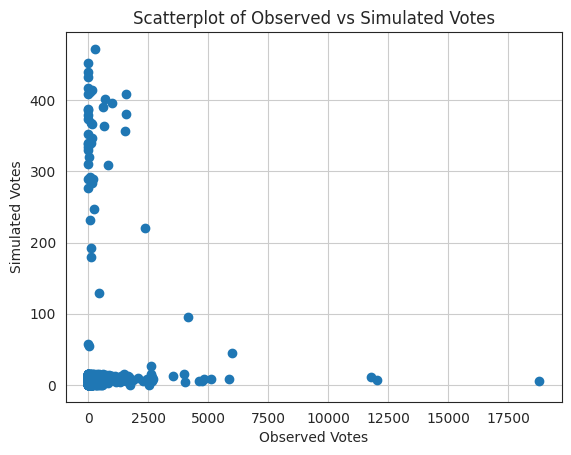

In [56]:
merged['sum_votes_observed'] = merged['votes_against_observed'] + merged['votes_defending_observed']
merged['sum_votes_simulated'] = merged['votes_against_simulated'] + merged['votes_defending_simulated']
import matplotlib.pyplot as plt

plt.scatter(merged['sum_votes_observed'], merged['sum_votes_simulated'])
plt.xlabel('Observed Votes')
plt.ylabel('Simulated Votes')
plt.title('Scatterplot of Observed vs Simulated Votes')
plt.grid(True)
plt.show()


## Analysis

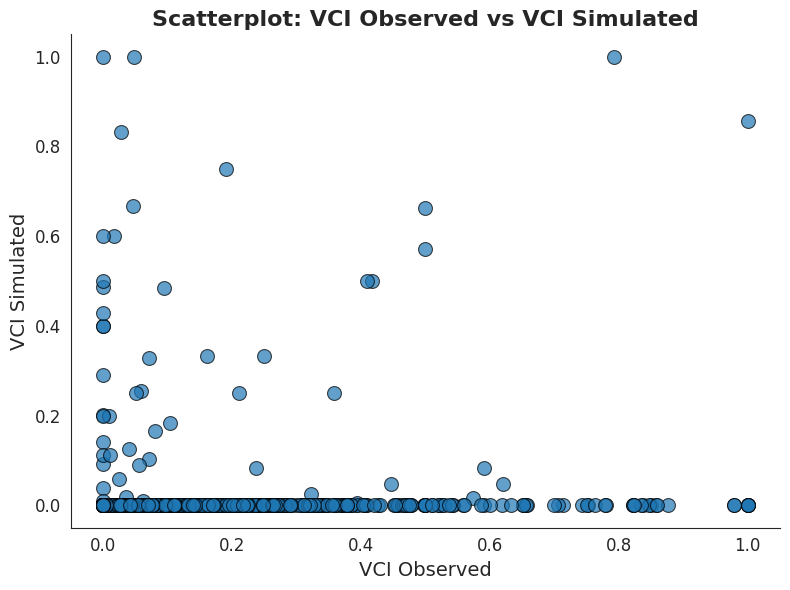

In [57]:


# Stile
sns.set_style("white")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='VCI_observed', 
    y='VCI_simulated', 
    data=merged,
    s=100,              # grandezza pallini
    alpha=0.7,          # trasparenza leggera
    edgecolor="k"       # bordo nero per eleganza
)

plt.title('Scatterplot: VCI Observed vs VCI Simulated', fontsize=16, weight="bold")
plt.xlabel('VCI Observed', fontsize=14)
plt.ylabel('VCI Simulated', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.despine()  # toglie gli assi in alto e a destra
plt.grid(False) # niente griglia

plt.tight_layout()
plt.show()


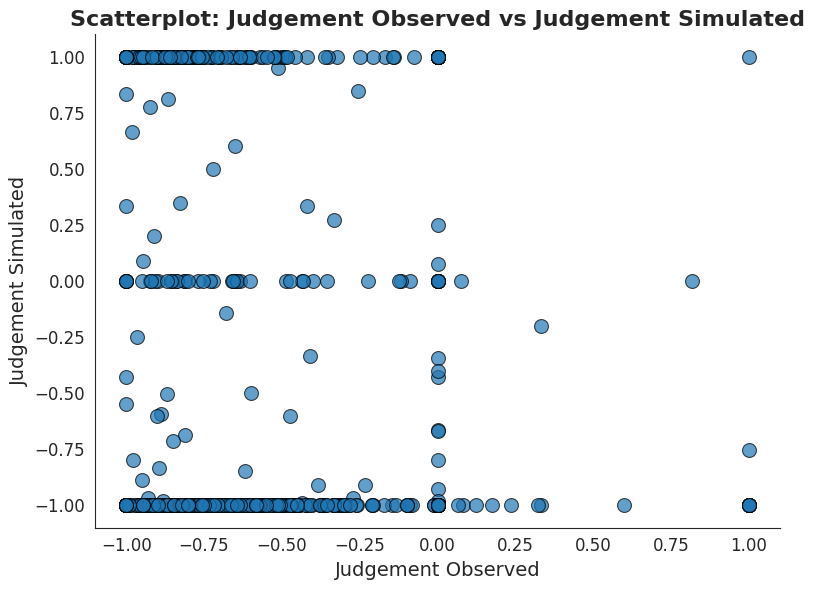

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns


# Stile
sns.set_style("white")

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='Judgement_observed', 
    y='Judgement_simulated', 
    data=merged,
    s=100,              # grandezza pallini
    alpha=0.7,          # trasparenza leggera
    edgecolor="k"       # bordo nero per eleganza
)

plt.title('Scatterplot: Judgement Observed vs Judgement Simulated', fontsize=16, weight="bold")
plt.xlabel('Judgement Observed', fontsize=14)
plt.ylabel('Judgement Simulated', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

sns.despine()  # toglie gli assi in alto e a destra
plt.grid(False) # niente griglia

plt.tight_layout()
plt.show()



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


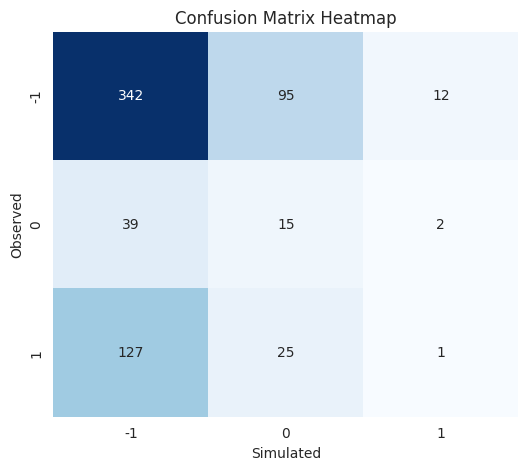

In [59]:
!pip install scikit-learn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Funzione per classificare il leaning
def classify_leaning(x):
    if x <= -0.33:
        return -1   # contrario
    elif x >= 0.33:
        return 1    # favorevole
    else:
        return 0    # neutro

# Applico la classificazione alle due colonne
merged['Class_simulated'] = merged['Judgement_simulated'].apply(classify_leaning)
merged['Class_observed'] = merged['Judgement_observed'].apply(classify_leaning)

# Matrice di confusione con sklearn
cm = confusion_matrix(merged['Class_simulated'],merged['Class_observed'], labels=[-1,0,1])

# Più leggibile con pandas
cm_df = pd.crosstab( merged['Class_simulated'], merged['Class_observed'],
                    rownames=['Observed'], colnames=['Simulated'], dropna=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Crea la heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False)

plt.title("Confusion Matrix Heatmap")
plt.show()


### Labels

In [60]:
import pandas as pd 
labels=pd.read_csv("/home/jacoponudo/Documents/LLM-CommunityNotes/data/labels/database_replication.csv")

In [63]:
labels['tweet_id'] = labels['tweet_id'].astype(str)
merged_with_labels = labels[['tweet_id','party']].merge(merged, on='tweet_id', how='right')
merged_with_labels.drop_duplicates(inplace=True)
merged_with_labels

,tweet_id,party,votes_against_observed,votes_defending_observed,VCI_observed,Judgement_observed,votes_against_simulated,votes_defending_simulated,VCI_simulated,Judgement_simulated,sum_votes_observed,sum_votes_simulated,Class_simulated,Class_observed
0,1384273265829416960,NaN,0,0,0.000000,0.000000,318,12,0.037736,-0.927273,0,330,-1,0
1,1547586884376834049,NaN,0,0,0.000000,0.000000,282,57,0.202128,-0.663717,0,339,-1,0
2,1586499372648484864,NaN,0,0,0.000000,0.000000,452,0,0.000000,-1.000000,0,452,-1,0
3,1587932950712225794,NaN,0,0,0.000000,0.000000,387,0,0.000000,-1.000000,0,387,-1,0
4,1600977526909706240,NaN,0,0,0.000000,0.000000,350,3,0.008571,-0.983003,0,353,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,1722687813148356983,republican,257,299,0.859532,0.075540,0,0,0.000000,0.000000,556,0,0,0
1182,1652147832034590721,democrat,1653,70,0.042347,-0.918746,0,0,0.000000,0.000000,1723,0,0,-1
1184,1420452986095087616,NaN,1,0,0.000000,-1.000000,0,0,0.000000,0.000000,1,0,0,-1
1185,1739008206565970147,unknown,61,29,0.475410,-0.355556,0,0,0.000000,0.000000,90,0,0,-1


In [64]:
merged_with_labels['delta'] = merged_with_labels['Judgement_simulated'] - merged_with_labels['Judgement_observed']
merged_with_labels=merged_with_labels
merged_with_labels[['delta', 'party']]


,delta,party
0,-0.927273,NaN
1,-0.663717,NaN
2,-1.000000,NaN
3,-1.000000,NaN
4,-0.983003,NaN
...,...,...
1179,-0.075540,republican
1182,0.918746,democrat
1184,1.000000,NaN
1185,0.355556,unknown


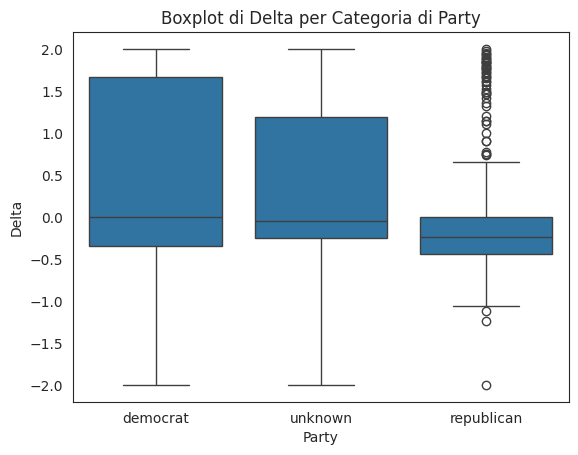

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='party', y='delta', data=merged_with_labels)
plt.xlabel('Party')
plt.ylabel('Delta')
plt.title('Boxplot di Delta per Categoria di Party')
plt.show()
### WHAAAT?

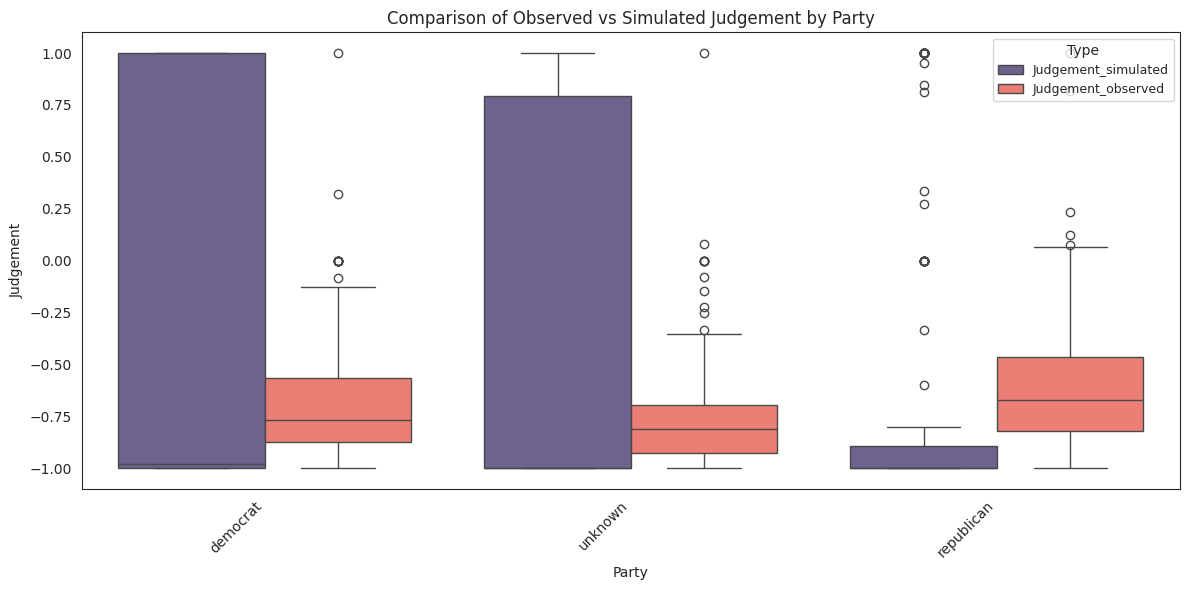

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Copia solo le colonne necessarie
df = merged_with_labels[['Judgement_simulated','Judgement_observed', 'party']].copy()

# Rimodella il dataframe in formato "long"
df_long = df.melt(id_vars='party',
                  value_vars=['Judgement_simulated','Judgement_observed'],
                  var_name='Type',
                  value_name='Judgement')

# Palette esotica
colors = {"Judgement_observed": "#FF6F61",  # rosso-corallo
          "Judgement_simulated": "#6B5B95"}  # viola-indaco

plt.figure(figsize=(12,6))

# Boxplot con hue
bp = sns.boxplot(data=df_long, x="party", y="Judgement", hue="Type",
                 palette=colors, showfliers=True)

# Rendere tratteggiato solo il box simulato
for i, artist in enumerate(bp.artists):
    # I box sono disegnati alternati: osservato, simulato, osservato, simulato...
    if i % 2 == 1:  # simulato
        artist.set_linestyle('--')
        artist.set_edgecolor(colors['Judgement_simulated'])
        artist.set_facecolor('none')  # solo bordo tratteggiato

plt.xticks(rotation=45, ha="right")
plt.xlabel("Party")
plt.ylabel("Judgement")
plt.title("Comparison of Observed vs Simulated Judgement by Party")

plt.legend(loc="upper right", fontsize=9, title='Type', title_fontsize=10)
plt.tight_layout()
plt.show()


In [68]:
merged_with_labels

,tweet_id,party,votes_against_observed,votes_defending_observed,VCI_observed,Judgement_observed,votes_against_simulated,votes_defending_simulated,VCI_simulated,Judgement_simulated,sum_votes_observed,sum_votes_simulated,Class_simulated,Class_observed,delta
0,1384273265829416960,NaN,0,0,0.000000,0.000000,318,12,0.037736,-0.927273,0,330,-1,0,-0.927273
1,1547586884376834049,NaN,0,0,0.000000,0.000000,282,57,0.202128,-0.663717,0,339,-1,0,-0.663717
2,1586499372648484864,NaN,0,0,0.000000,0.000000,452,0,0.000000,-1.000000,0,452,-1,0,-1.000000
3,1587932950712225794,NaN,0,0,0.000000,0.000000,387,0,0.000000,-1.000000,0,387,-1,0,-1.000000
4,1600977526909706240,NaN,0,0,0.000000,0.000000,350,3,0.008571,-0.983003,0,353,-1,0,-0.983003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,1722687813148356983,republican,257,299,0.859532,0.075540,0,0,0.000000,0.000000,556,0,0,0,-0.075540
1182,1652147832034590721,democrat,1653,70,0.042347,-0.918746,0,0,0.000000,0.000000,1723,0,0,-1,0.918746
1184,1420452986095087616,NaN,1,0,0.000000,-1.000000,0,0,0.000000,0.000000,1,0,0,-1,1.000000
1185,1739008206565970147,unknown,61,29,0.475410,-0.355556,0,0,0.000000,0.000000,90,0,0,-1,0.355556


/tmp/ipykernel_16098/714888451.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_with_labels['party'].fillna('NA', inplace=True)
/tmp/ipykernel_16098/714888451.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Class_simulated'] = subset['Judgement_simulated'].apply(c

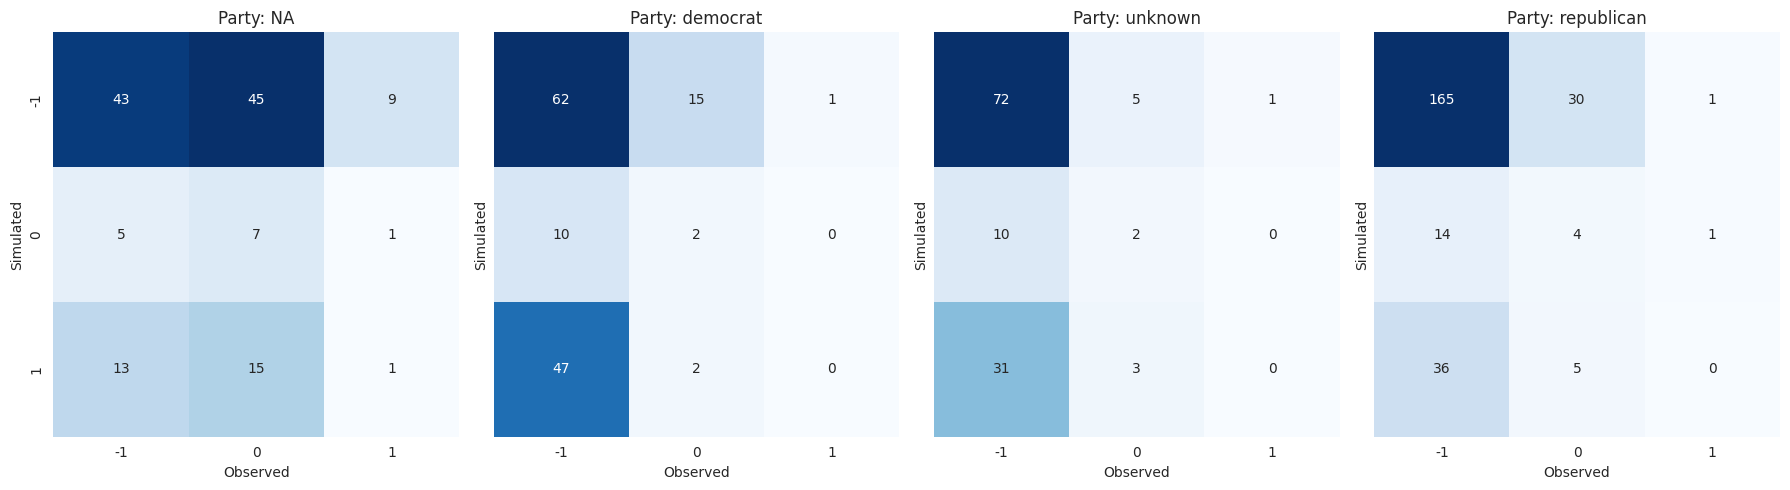

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Etichette per le classi (-1, 0, 1)
labels = [-1, 0, 1]

# Prepara la figura con 1 riga e 3 colonne
merged_with_labels['party'].fillna('NA', inplace=True)
parties = merged_with_labels['party'].unique()
fig, axes = plt.subplots(1, len(parties), figsize=(18, 5), sharey=True)

for ax, party in zip(axes, parties):
    subset = merged_with_labels[merged_with_labels['party'] == party]

    # Applico la classificazione
    subset['Class_simulated'] = subset['Judgement_simulated'].apply(classify_leaning)
    subset['Class_observed'] = subset['Judgement_observed'].apply(classify_leaning)

    # Matrice di confusione con sklearn
    cm = confusion_matrix(subset['Class_simulated'], subset['Class_observed'], labels=labels)

    # Converti in DataFrame per la heatmap, mantenendo tutti gli zeri
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Crea la heatmap
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Party: {party}")
    ax.set_xlabel("Observed")
    ax.set_ylabel("Simulated")

plt.tight_layout()
plt.show()


In [ ]:
print("Number of Notes:", tweet_ratings_simulated['tweet_id'].nunique())
print("Number of Notes:", tweet_ratings_observed['tweet_id'].nunique())

print("Number of Notes:", notes_simulated['note_id'].nunique())
print("Number of Notes:", notes_observed['noteId'].nunique())

print("Number of Ratings:", tweet_ratings_simulated.shape[0])# Errore
print("Number of Ratings:", tweet_ratings_observed.shape[0])


Number of Notes: 658
Number of Notes: 658
Number of Notes: 793
Number of Notes: 1570
Number of Ratings: 658
Number of Ratings: 658


614


In [123]:
print("Number of Tweets:")
print()
print('Simulated')
print(notes_simulated['tweet_id'].nunique())
print()
print('Observed')
print(notes['tweetId'].nunique())

Number of Tweets:

Simulated
615

Observed
615


In [86]:
print("Number of Notes:")
print()
print('Simulated ')
print(notes_simulated[['type']].value_counts())
print()
print('Observed ')
print(notes[['classification']].value_counts())

Number of Notes:

Simulated 
type          
misleading        586
not_misleading    207
Name: count, dtype: int64

Observed 
classification                       
MISINFORMED_OR_POTENTIALLY_MISLEADING    113
NOT_MISLEADING                            20
Name: count, dtype: int64


In [ ]:
print('Simulated ')
print(notes_simulated[['type']].value_counts())
print()
print('Observed ')
print(notes[['classification']].value_counts())

# Data Breakdown

## Notes

In [31]:
notes_simulated[['classification']].value_counts()

classification
misleading        586
not_misleading    207
Name: count, dtype: int64

In [33]:
notes_observed[['classification']].value_counts()

classification                       
MISINFORMED_OR_POTENTIALLY_MISLEADING    1294
NOT_MISLEADING                            276
Name: count, dtype: int64

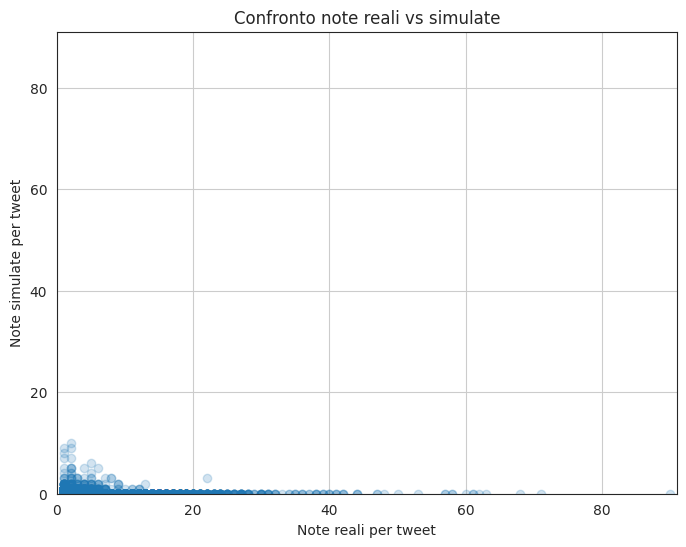

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Raggruppa e conta le note per tweet
simulated_counts = notes_simulated.groupby('tweet_id').size().reset_index(name='simulated')
real_counts = notes.groupby('tweetId').size().reset_index(name='real')

# Rinomina colonne per il merge
real_counts = real_counts.rename(columns={'tweetId': 'tweet_id'})

# Converte gli ID a stringhe
simulated_counts['tweet_id'] = simulated_counts['tweet_id'].astype(str)
real_counts['tweet_id'] = real_counts['tweet_id'].astype(str)

# Fai il merge sui tweet_id
df_plot = pd.merge(real_counts, simulated_counts, on='tweet_id', how='outer').fillna(0)

# Crea lo scatterplot
plt.figure(figsize=(8,6))
plt.scatter(df_plot['real'], df_plot['simulated'], alpha=0.2)
plt.xlabel('Note reali per tweet')
plt.ylabel('Note simulate per tweet')
plt.title('Confronto note reali vs simulate')
plt.grid(True)
plt.xlim(0, df_plot[['real', 'simulated']].values.max() + 1)
plt.ylim(0, df_plot[['real', 'simulated']].values.max() + 1)
plt.show()


In [37]:
ratings_observed[ratings_observed['ratedOnTweetId']!=-1]
ratings_simulated

,note_id,helpfulness,tweet_id,classification,votes_against,votes_defending
0,1,helpful,1384273265829416960,misleading,1,0
1,1,helpful,1384273265829416960,misleading,1,0
2,1,helpful,1384273265829416960,misleading,1,0
3,1,helpful,1384273265829416960,misleading,1,0
4,1,helpful,1384273265829416960,misleading,1,0
...,...,...,...,...,...,...
20389,330,helpful,1677710843138457601,misleading,1,0
20390,442,helpful,nan,NaN,0,0
20391,330,helpful,1677710843138457601,misleading,1,0
20392,295,helpful,1677710843138457601,misleading,1,0
